In [1]:
import librosa
import librosa.display
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import datetime as dt
from keras import layers
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split

os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [2]:
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
random.seed(100)

In [3]:
# define parameters
batch_size = 32
minimum_len = 128
epochs = 200
val_period = 10 # 몇 epoch에 한번씩 validation?
loss_function = 'categorical_crossentropy'
activation_function = 'softmax'

### Getting file names

In [4]:
#currdir= os.getcwd()
rootdir = '/home/taejoon/PhysioNetChallenge'
input_directory = os.path.join(rootdir, 'Training_WFDB')
mel_name = 'Mel_data_20200402_128' 
mel_directory = os.path.join(rootdir, mel_name)
results_directory = os.path.join(rootdir, 'results')
#save_directory = os.path.join(currdir, '')
if not os.path.isdir(input_directory):
        os.mkdir(input_directory)
if not os.path.isdir(mel_directory):
        os.mkdir(mel_directory)
if not os.path.isdir(results_directory):
        os.mkdir(results_directory)                       

In [5]:
# Find files
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)

In [6]:
input_file_names = sorted(input_files)
input_file_names

['A0001.mat',
 'A0002.mat',
 'A0003.mat',
 'A0004.mat',
 'A0005.mat',
 'A0006.mat',
 'A0007.mat',
 'A0008.mat',
 'A0009.mat',
 'A0010.mat',
 'A0011.mat',
 'A0012.mat',
 'A0013.mat',
 'A0014.mat',
 'A0015.mat',
 'A0016.mat',
 'A0017.mat',
 'A0018.mat',
 'A0019.mat',
 'A0020.mat',
 'A0021.mat',
 'A0022.mat',
 'A0023.mat',
 'A0024.mat',
 'A0025.mat',
 'A0026.mat',
 'A0027.mat',
 'A0028.mat',
 'A0029.mat',
 'A0030.mat',
 'A0031.mat',
 'A0032.mat',
 'A0033.mat',
 'A0034.mat',
 'A0035.mat',
 'A0036.mat',
 'A0037.mat',
 'A0038.mat',
 'A0039.mat',
 'A0040.mat',
 'A0041.mat',
 'A0042.mat',
 'A0043.mat',
 'A0044.mat',
 'A0045.mat',
 'A0046.mat',
 'A0047.mat',
 'A0048.mat',
 'A0049.mat',
 'A0050.mat',
 'A0051.mat',
 'A0052.mat',
 'A0053.mat',
 'A0054.mat',
 'A0055.mat',
 'A0056.mat',
 'A0057.mat',
 'A0058.mat',
 'A0059.mat',
 'A0060.mat',
 'A0061.mat',
 'A0062.mat',
 'A0063.mat',
 'A0064.mat',
 'A0065.mat',
 'A0066.mat',
 'A0067.mat',
 'A0068.mat',
 'A0069.mat',
 'A0070.mat',
 'A0071.mat',
 'A007

### Code for extracting only single-label subjects

In [7]:
# Find unique number of classes  
def get_unique_classes(input_directory,files):

    unique_classes=set()
    for f in files:
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        unique_classes.add(c.strip())

    return sorted(unique_classes)

unique_classes = get_unique_classes(input_directory, input_files)
# Creating one-hot vector for Y
# num = np.unique(classes, axis=0)
class2index = {}
for a, b in enumerate(unique_classes):
    class2index[b] = a
#class2index

def one_hot_encoding(one_hot_vector,y, class2index):

       ind=class2index[y]
       one_hot_vector[ind]=1
       return one_hot_vector

In [8]:
class2index

{'AF': 0,
 'I-AVB': 1,
 'LBBB': 2,
 'Normal': 3,
 'PAC': 4,
 'PVC': 5,
 'RBBB': 6,
 'STD': 7,
 'STE': 8}

In [9]:
# Search for multi-label subjects
def searching_overlap(input_directory,class2index, input_file_names):
    multiclasses=[]
    multisubjects=[]
    number = []
    for file in input_file_names:
        f=file
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    if len(tmp)>1:
                        one_hot_vector = [0]*(len(class2index))
                        for c in tmp:
                            one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                        multiclasses.append(one_hot_vector)
                        multisubjects.append(g)
                        number.append(len(tmp))
    return multisubjects, multiclasses, number

In [10]:
classes_orig= [x.replace('.mat', '.hea') for x in input_file_names] # total subjects
classes_multi, _, _ = searching_overlap(input_directory,class2index, input_file_names)
classes_single = [x for x in classes_orig if x not in classes_multi]
classes_single = [x.replace('.hea', '.mat') for x in classes_single]

In [11]:
np.shape(classes_single)

(6401,)

In [12]:
classes_single

['A0001.mat',
 'A0002.mat',
 'A0003.mat',
 'A0004.mat',
 'A0005.mat',
 'A0006.mat',
 'A0007.mat',
 'A0008.mat',
 'A0009.mat',
 'A0010.mat',
 'A0011.mat',
 'A0012.mat',
 'A0013.mat',
 'A0014.mat',
 'A0015.mat',
 'A0016.mat',
 'A0017.mat',
 'A0018.mat',
 'A0019.mat',
 'A0020.mat',
 'A0021.mat',
 'A0022.mat',
 'A0023.mat',
 'A0024.mat',
 'A0025.mat',
 'A0026.mat',
 'A0027.mat',
 'A0028.mat',
 'A0029.mat',
 'A0030.mat',
 'A0031.mat',
 'A0032.mat',
 'A0033.mat',
 'A0034.mat',
 'A0035.mat',
 'A0036.mat',
 'A0037.mat',
 'A0038.mat',
 'A0039.mat',
 'A0040.mat',
 'A0041.mat',
 'A0042.mat',
 'A0044.mat',
 'A0045.mat',
 'A0046.mat',
 'A0047.mat',
 'A0048.mat',
 'A0049.mat',
 'A0050.mat',
 'A0051.mat',
 'A0052.mat',
 'A0053.mat',
 'A0054.mat',
 'A0055.mat',
 'A0056.mat',
 'A0057.mat',
 'A0058.mat',
 'A0059.mat',
 'A0060.mat',
 'A0061.mat',
 'A0062.mat',
 'A0063.mat',
 'A0064.mat',
 'A0065.mat',
 'A0066.mat',
 'A0067.mat',
 'A0068.mat',
 'A0069.mat',
 'A0070.mat',
 'A0071.mat',
 'A0072.mat',
 'A007

In [13]:
# double-checking if classes_single have single-label
a, b, c  = searching_overlap(input_directory,class2index,classes_single)
a

[]

In [14]:
# we can safely use classes_single as input_file_names
input_file_names = classes_single
random.shuffle(input_file_names)
np.shape(input_file_names)

(6401,)

### Shuffle and divide files into train/eval/test

In [15]:
data, data_test = train_test_split(input_file_names, test_size = 0.2, train_size = 0.8, shuffle=True)
data_train, data_val = train_test_split(data, test_size = 0.25, train_size = 0.75, shuffle=True)

In [16]:
print(np.shape(data_train), np.shape(data_val), np.shape(data_test))

(3840,) (1280,) (1281,)


### CNN Model

In [17]:
from keras.applications.densenet import DenseNet169
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Model 

input_tensor = Input(shape=(128, 128, 12))
base_model = DenseNet169(input_tensor=input_tensor, weights=None, include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
pred = Dense(9, activation=activation_function)(x)

model = Model(inputs=base_model.input, outputs=pred)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 12) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 12) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   37632       zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [19]:
def block_feature(sequence_en, minimum_len): 
    new_en = []
    if len(sequence_en) > minimum_len:  # 길이가 minimum보다 긴 경우
        start = random.randint(0,len(sequence_en)-minimum_len)    
        new_en = sequence_en[start:start+minimum_len]
    elif len(sequence_en) == minimum_len: # 길이가 minimum
        new_en = sequence_en
    else: 
        assert len(sequence_en) <= minimum_len
    return new_en

In [20]:
def exploratory_look(input_directory,file, class2index):
    
    classes = []

    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                print(tmp, len(tmp))
    return tmp            

for file in input_file_names:
    tmp = exploratory_look(input_directory, file, class2index)

['Normal\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['PAC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['STE\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['STD\n'] 1
['Normal\n'] 1
['AF\n'] 1
['STE\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['LBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['AF\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['AF\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['LBBB\n'] 1
['PVC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['LBBB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['STE\n'] 1
['Normal\n'] 1
['LBBB\n'] 1
['STD\n'] 1
['

['STD\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['AF\n'] 1
['PAC\n'] 1
['STD\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['LBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['LBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['STD\n'] 1
['STD\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['LBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['STD\n'] 1
['AF\n'] 1
['STD\n'] 1
['STE\n'] 1
['PVC\n'] 1
['AF\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['STD\n'] 1
['AF\n'

['I-AVB\n'] 1
['STD\n'] 1
['AF\n'] 1
['STD\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['STD\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['AF\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['STE\n'] 1
['STD\n'] 1
['STD\n'] 1
['STD\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['AF\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['STE\n'] 1
['I-AVB\n'] 1
['PAC\n'] 1
['STE\n'] 1
['STD\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['STD\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['STE\n'] 1
['LBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['P

['PAC\n'] 1
['I-AVB\n'] 1
['LBBB\n'] 1
['LBBB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['Normal\n'] 1
['STD\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['STD\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['STE\n'] 1
['AF\n'] 1
['STD\n'] 1
['Normal\n'] 1
['STE\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['STE\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['STD\n'] 1
['PAC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['STE\n'] 1
['STE\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['Normal\n'] 1
['No

['RBBB\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['PAC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['STE\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['STE\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['STD\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['AF\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['STD\n'] 1
['P

['STD\n'] 1
['Normal\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['LBBB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['PAC\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['PVC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['STE\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['STD\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['STD\n'] 1
['Normal\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['STD\n'] 1
['PVC\n'] 1
['AF\n'] 1
['PVC\n'

['Normal\n'] 1
['AF\n'] 1
['STD\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['STD\n'] 1
['PAC\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['LBBB\n'] 1
['PVC\n'] 1
['PVC\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['AF\n'] 1
['STD\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['STD\n'] 1
['PAC\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['PVC\n'] 1
['STD\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['AF\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['AF\n'] 1
['Norma

['AF\n'] 1
['RBBB\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['PAC\n'] 1
['Normal\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['STE\n'] 1
['PAC\n'] 1
['AF\n'] 1
['LBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['AF\n'] 1
['AF\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['PAC\n'] 1
['PAC\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['AF\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['STE\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['LBBB\n'] 1
['PVC\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PAC\n'] 

['PVC\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['STE\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['STD\n'] 1
['STE\n'] 1
['RBBB\n'] 1
['RBBB\n'] 1
['PAC\n'] 1
['RBBB\n'] 1
['AF\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['AF\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['LBBB\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['I-AVB\n'] 1
['I-AVB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['RBBB\n'] 1
['LBBB\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['STD\n'] 1
['Normal\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['I-AVB\n'] 1
['PVC\n'] 1
['Normal\n'] 1
['STD\n'] 1
['AF\n'] 1
['PAC\n'] 1
['PAC\n'] 1
['LBBB\n'] 1
['PAC\n'] 1
['PVC\n'] 1
['AF\n'] 1
['Normal\n'] 1
['AF\n'] 1
['PVC\n'] 1
['STD\n'] 1
['STD\n'] 1
['AF\n'] 1
['PAC\n'] 1
['AF\n'] 1
['LBBB\n'] 1
['I-AVB\n'] 1
['AF\n'] 1
['RBBB\n'] 1
['LBBB\n'] 1
['AF\n'] 1
['Normal\n'] 1
['STD\n'] 1
['I-AVB\n'] 1
['RBBB\n'] 1
['Normal\n'] 1
['Normal\n'] 1
['RBBB\n'

In [21]:
# Get classes of sorted file names
def get_labels(input_directory,file, class2index):
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                one_hot_vector = [0]*(len(class2index))
                for c in tmp:
                    one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                
    return one_hot_vector

In [22]:
def randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len): # step = 0, 1, 2, 3....
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data_train[start:end]
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        mel_files.append(clip_file)
        
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    return mel_files, classes

In [23]:
def randextract_mels_val(curr_range_start, curr_range_end, data_val, mel_directory, class2index, minimum_len): # step = 0, 1, 2, 3....
    mel_files = []
    classes = []
    curr_file_indices = data_val[int(curr_range_start):int(curr_range_end)]
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        mel_files.append(clip_file)
        
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    return mel_files, classes

In [24]:
model.compile(loss=loss_function,
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [25]:
def train(data_train, mel_directory, batch_size, class2index, minimum_len): 
    
    loss=[]
    acc = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps):
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len)
        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))
        train_loss_tmp = model.train_on_batch(batch_mels, batch_labels)
        loss.append(train_loss_tmp[0])
        acc.append(train_loss_tmp[1])

    loss = np.mean(np.array(loss))
    acc = np.mean(np.array(acc))
    return loss, acc

In [30]:
def validation(data, epochs, mel_directory, minimum_len,ct, per_val): 
    # 1. 파일 읽어오기
    # 2. 128 길이의 block들로 쪼개기 (끄트머리 버리기-> np.floor)
    # 3. 각 block -> model.predict -> logit 가져오기 
    # 4. Block들간 평균내서 1 or 0 부여
    # 5. 실제 label과 비교
    

    curr_range_start = (ct-1)*per_val
    curr_range_end = ct*per_val
    scores = []
    curr_file_indices = data[curr_range_start:curr_range_end]
    accuracy=np.zeros(len(curr_file_indices))
    for i, file in enumerate(curr_file_indices):
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        logits=[]
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            curr_block = tmp_file[start:end]
            curr_block = np.expand_dims(curr_block,0)

            logit = model.predict(curr_block) # sigmoid 거쳐서 나온 것
            logits.append(logit)
        
        average = np.mean(np.squeeze(logits), axis=0)
        scores.append(average)
        
        pred_ans = np.argmax(average)
#         average = np.zeros(np.shape(average))
#         average[ans] = 1
        
#         average[average>=0.5] = 1
#         average[average<0.5] = 0

#         if average[average<0]:
#             print('Error: output of sigmoid should be between 0 and 1')

        true_label = get_labels(input_directory, file, class2index)
    
        true_ans = np.argmax(true_label)
        
#         if np.array_equal(average, true_label): # predicted와 실제 label이 아예 같아야만 정답으로 인정
        if int(true_ans) == int(pred_ans):
            accuracy[i] = 1
    avg_acc = np.mean(accuracy)
    return avg_acc

In [53]:
def test(data, minimum_len, model): # valid에서 이 함수 부를 떄는 ct 인자로 넣어주기
    # 1. 파일 읽어오기
    # 2. 128 길이의 block들로 쪼개기 (끄트머리 버리기-> np.floor)
    # 3. 각 block -> model.predict -> logit 가져오기 
    # 4. Block들간 평균내서 1 or 0 부여
    # 5. 실제 label과 비교 

    curr_range_start = 0
    curr_range_end = len(data)
    curr_file_indices = data[curr_range_start:curr_range_end]
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(curr_file_indices))
    for i, file in enumerate(curr_file_indices):
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        logits=[]
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            curr_block = tmp_file[start:end]
            curr_block = np.expand_dims(curr_block,0)

            logit = model.predict(curr_block) # sigmoid 거쳐서 나온 것
            logits.append(logit)

        average = np.mean(np.squeeze(logits), axis=0)
        scores.append(average)
#         average[average>=0.5] = 1
#         average[average<0.5] = 0
        pred_ans = np.argmax(average)
    
        if average[average<0]:
            print('Error: output of sigmoid should be between 0 and 1')
#         predicted_labels.append(average)    
        predicted_labels.append(pred_ans)
        true_label = get_labels(input_directory, file, class2index)
        true_ans = np.argmax(true_label)
#         if np.array_equal(average, true_label): # predicted와 실제 label이 아예 같아야만 정답으로 인정
        if int(true_ans) == int(pred_ans):
            accuracy[i] = 1

    avg_acc = np.mean(accuracy)
    return avg_acc, scores, predicted_labels

In [31]:
ct = 0
val_loss_sum = []
val_acc_sum=[]
train_loss_sum=[]
train_acc_sum=[]
 
# per_epoch = epochs/val_period # how many validation sets we need: divide total epochs (1000) by 20
per_val = int(np.floor(len(data_val)/epochs))
for num_epoch in range(epochs):
    ct+=1
    train_loss, train_acc = train(data_train, mel_directory, batch_size, class2index, minimum_len)
    print('\nEpoch',num_epoch+1,'train_loss:',f'{train_loss:.3f}','train_acc:',f'{train_acc:.3f}',"\t", dt.datetime.now())
    model_output = "ecg_mel_E%02dL%.2f" % (num_epoch, train_loss)
    save_name = os.path.join(results_directory, model_output)
#     validation(data, epochs, mel_directory, minimum_len,ct)
    val_acc = validation(data_val, epochs, mel_directory, minimum_len, ct, per_val)
    print('\nValidation', ct,'valid_acc:',f'{val_acc:.3f}',"\t", dt.datetime.now()) 
    val_acc_sum.append(val_acc)
    train_loss_sum.append(train_loss)
    train_acc_sum.append(train_acc)

    model.save(save_name)


Epoch 1 train_loss: 1.245 train_acc: 0.579 	 2020-04-13 08:39:56.425312

Validation 1 valid_acc: 0.000 	 2020-04-13 08:39:56.862988

Epoch 2 train_loss: 1.164 train_acc: 0.613 	 2020-04-13 08:40:16.386315

Validation 2 valid_acc: 0.000 	 2020-04-13 08:40:17.074615

Epoch 3 train_loss: 1.078 train_acc: 0.645 	 2020-04-13 08:40:36.606555

Validation 3 valid_acc: 0.333 	 2020-04-13 08:40:36.961515

Epoch 4 train_loss: 1.022 train_acc: 0.659 	 2020-04-13 08:40:56.554500

Validation 4 valid_acc: 0.167 	 2020-04-13 08:40:57.138794

Epoch 5 train_loss: 0.986 train_acc: 0.680 	 2020-04-13 08:41:16.884758

Validation 5 valid_acc: 0.500 	 2020-04-13 08:41:17.328237

Epoch 6 train_loss: 0.916 train_acc: 0.693 	 2020-04-13 08:41:36.932252

Validation 6 valid_acc: 0.167 	 2020-04-13 08:41:37.803517

Epoch 7 train_loss: 0.880 train_acc: 0.709 	 2020-04-13 08:41:57.414970

Validation 7 valid_acc: 0.667 	 2020-04-13 08:41:57.824536

Epoch 8 train_loss: 0.834 train_acc: 0.718 	 2020-04-13 08:42:17.471


Epoch 62 train_loss: 0.139 train_acc: 0.953 	 2020-04-13 09:00:27.831142

Validation 62 valid_acc: 0.167 	 2020-04-13 09:00:28.427520

Epoch 63 train_loss: 0.154 train_acc: 0.949 	 2020-04-13 09:00:48.192375

Validation 63 valid_acc: 0.333 	 2020-04-13 09:00:48.636097

Epoch 64 train_loss: 0.141 train_acc: 0.957 	 2020-04-13 09:01:08.363457

Validation 64 valid_acc: 0.167 	 2020-04-13 09:01:08.740424

Epoch 65 train_loss: 0.128 train_acc: 0.960 	 2020-04-13 09:01:28.403601

Validation 65 valid_acc: 0.500 	 2020-04-13 09:01:28.830232

Epoch 66 train_loss: 0.128 train_acc: 0.956 	 2020-04-13 09:01:48.491812

Validation 66 valid_acc: 0.167 	 2020-04-13 09:01:48.886648

Epoch 67 train_loss: 0.129 train_acc: 0.958 	 2020-04-13 09:02:08.625701

Validation 67 valid_acc: 0.167 	 2020-04-13 09:02:09.171337

Epoch 68 train_loss: 0.129 train_acc: 0.958 	 2020-04-13 09:02:28.868127

Validation 68 valid_acc: 0.500 	 2020-04-13 09:02:29.477181

Epoch 69 train_loss: 0.110 train_acc: 0.961 	 2020-04-


Validation 122 valid_acc: 0.333 	 2020-04-13 09:20:41.375980

Epoch 123 train_loss: 0.076 train_acc: 0.977 	 2020-04-13 09:21:01.053445

Validation 123 valid_acc: 0.667 	 2020-04-13 09:21:01.528600

Epoch 124 train_loss: 0.066 train_acc: 0.978 	 2020-04-13 09:21:21.227741

Validation 124 valid_acc: 0.167 	 2020-04-13 09:21:21.638631

Epoch 125 train_loss: 0.077 train_acc: 0.975 	 2020-04-13 09:21:41.296403

Validation 125 valid_acc: 0.500 	 2020-04-13 09:21:41.906903

Epoch 126 train_loss: 0.067 train_acc: 0.980 	 2020-04-13 09:22:01.578728

Validation 126 valid_acc: 0.167 	 2020-04-13 09:22:02.107884

Epoch 127 train_loss: 0.068 train_acc: 0.976 	 2020-04-13 09:22:21.798418

Validation 127 valid_acc: 0.500 	 2020-04-13 09:22:22.407949

Epoch 128 train_loss: 0.077 train_acc: 0.977 	 2020-04-13 09:22:42.105109

Validation 128 valid_acc: 0.333 	 2020-04-13 09:22:42.682617

Epoch 129 train_loss: 0.064 train_acc: 0.981 	 2020-04-13 09:23:02.384750

Validation 129 valid_acc: 0.167 	 2020-0


Validation 182 valid_acc: 0.500 	 2020-04-13 09:40:55.905926

Epoch 183 train_loss: 0.041 train_acc: 0.988 	 2020-04-13 09:41:15.590274

Validation 183 valid_acc: 0.333 	 2020-04-13 09:41:15.944410

Epoch 184 train_loss: 0.064 train_acc: 0.982 	 2020-04-13 09:41:35.623993

Validation 184 valid_acc: 0.500 	 2020-04-13 09:41:36.062121

Epoch 185 train_loss: 0.050 train_acc: 0.985 	 2020-04-13 09:41:55.752658

Validation 185 valid_acc: 0.833 	 2020-04-13 09:41:56.279871

Epoch 186 train_loss: 0.042 train_acc: 0.987 	 2020-04-13 09:42:15.959578

Validation 186 valid_acc: 0.500 	 2020-04-13 09:42:16.505213

Epoch 187 train_loss: 0.060 train_acc: 0.983 	 2020-04-13 09:42:36.235033

Validation 187 valid_acc: 0.667 	 2020-04-13 09:42:36.720188

Epoch 188 train_loss: 0.028 train_acc: 0.993 	 2020-04-13 09:42:56.402420

Validation 188 valid_acc: 0.500 	 2020-04-13 09:42:56.809920

Epoch 189 train_loss: 0.051 train_acc: 0.987 	 2020-04-13 09:43:16.512187

Validation 189 valid_acc: 0.833 	 2020-0

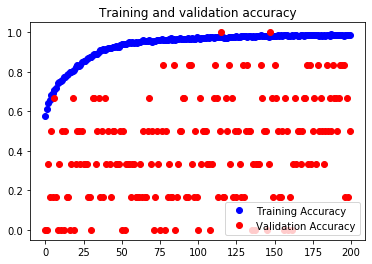

<Figure size 432x288 with 0 Axes>

In [33]:
x_range = range(epochs)
plt.plot(x_range, train_acc_sum, 'bo', label='Training Accuracy')
plt.plot(x_range, val_acc_sum, 'ro', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# plt.plot(x_range, train_loss_sum, 'bo', label='Training Loss')
# plt.plot(x_range, val_loss_sum, 'ro', label='Validation Loss')
# plt.title('Training and validation loss')
# plt.legend()

plt.show()

### Now, test with test data

In [ ]:
# Scoring:

# For each 12-lead ECG recording, your algorithm must identify a set of one or more classes as well as a probability or confidence score for each class. 

# Example: 
# #Record ID
#  AF, I-AVB, LBBB, Normal, RBBB, PAC,  PVC,  STD, STE
#   1,     1,    0,      0,    0,   0,   0,     0,   0
# 0.9,   0.6,  0.2,   0.05,  0.2, 0.35, 0.35, 0.1, 0.1

Since some recordings may have multiple labels, we normalize their contributions to these scoring functions so that each recording, not each class, makes an equal contribution. For example, if a recording has six classes, and your classifier identifies three labels correctly, identifies one label incorrectly, and misses two labels, then we increment the true positives by 3/6, false positives by 1/6, and false negatives by 2/6 for both scoring functions.

In [ ]:
# def test(data_test, mel_directory, class2index, minimum_len, model): 
    
#     metrics = []
#     batch_mels, batch_labels = randextract_mels_val(0, len(data_test)-1, data_val, mel_directory, class2index, minimum_len)
#     # although rendextract_mels_val, you can use the same function fpr test
#     batch_mels = np.asarray(batch_mels)
#     batch_labels = np.asarray(np.squeeze(batch_labels))
#     test_loss_tmp = model.test_on_batch(batch_mels, batch_labels)
#     loss = test_loss_tmp[0]
#     acc = test_loss_tmp[1]
# #     metrics.append(test_loss_tmp)

# #     metrics = np.mean(np.array(metrics))
#     return loss, acc

In [50]:
class2index = {'AF': 0,
               'I-AVB': 1,
               'LBBB': 2,
               'Normal': 3,
               'PAC': 4,
               'PVC': 5,
               'RBBB': 6,
               'STD': 7,
               'STE': 8}
classes = class2index.keys()

def save_challenge_predictions(data, scores, predicted_labels, classes):    
    for i, filename in enumerate(data):
        curr_score = scores[i]
        curr_label = predicted_labels[i]
        new_file = filename.replace('.mat','.csv')
        output_file = os.path.join(output_directory,new_file)
        recording = new_file.replace('.csv', '')
        # Include the filename as the recording number
        recording_string = '#{}'.format(recording)
        class_string = ','.join(classes)
        label_string = ','.join(str(i) for i in curr_label)
        score_string = ','.join(str(i) for i in curr_score)

        with open(output_file, 'w') as f:
            f.write(recording_string + '\n' + class_string + '\n' + label_string + '\n' + score_string + '\n')

In [ ]:
# load model
#  test(data, epochs, minimum_len,flag='val', ct=None): # valid에서 이 함수 부를 떄는 ct 인자로 넣어주기
rootdir = '/home/taejoon/PhysioNetChallenge'
results_directory = os.path.join(rootdir, 'results', 'csvfiles')
# model = tf.keras.models.load_model(os.path.join(results_directory, "ecg_mel_E200*"))
avg_acc, scores, predicted_labels = test(data_test, minimum_len, model)

#     print('\nTest result: loss:',f'{test_metrics[0]:.3f}','accuracy:', f'{test_metrics[1]:.3f}',"\t", dt.datetime.now())





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
